<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## RNN many-to-one

#### Datos
El objecto es utilizar una serie de sucuencias númericas (datos sintéticos) para poner a prueba el uso de las redes RNN. Este ejemplo se inspiró en otro artículo, lo tienen como referencia en el siguiente link:\
[LINK](https://stackabuse.com/solving-sequence-problems-with-lstm-in-keras/)

In [ ]:
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
# torchsummar actualmente tiene un problema con las LSTM, por eso
# se utiliza torchinfo, un fork del proyecto original con el bug solucionado
!pip3 install torchinfo
from torchinfo import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

--2022-05-29 21:17:28--  http://torch_helpers.py/
Resolving torch_helpers.py (torch_helpers.py)... failed: Name or service not known.
wget: unable to resolve host address ‘torch_helpers.py’
--2022-05-29 21:17:28--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23883 (23K) [text/plain]
Saving to: ‘torch_helpers.py’

torch_helpers.py    100%[===================>]  23.32K  --.-KB/s    in 0s      

2022-05-29 21:17:29 (91.1 MB/s) - ‘torch_helpers.py’ saved [23883/23883]

FINISHED --2022-05-29 21:17:29--
Total wall clock time: 0.1s
Downloaded: 1 files, 23K in 0s (91.1 MB/s)


In [ ]:
def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    valid_loss = []

    # Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_data)

            # Computo el error de la salida comparando contra las etiquetas
            loss = criterion(output, train_target)

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()

        # Calculo la media de error para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)

        # Realizo el paso de validación computando error y accuracy, y
        # almacenando los valores para imprimirlos y graficarlos
        valid_data, valid_target = iter(valid_loader).next()
        output = model(valid_data)
        
        epoch_valid_loss = criterion(output, valid_target).item()
        valid_loss.append(epoch_valid_loss)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Valid Loss {epoch_valid_loss:.3f}")

    history = {
        "loss": train_loss,
        "val_loss": valid_loss,
    }
    return history

In [ ]:
# Generar datos sintéticos
X = list()
y = list()

# X será una lista de 1 a 45 agrupado de a 3 números consecutivos
# [ [1, 2, 3], [4, 5, 6], ....]
X = [ [x, x+1, x+2] for x in range(1, 46, 3)]

# "y" (target) se obtiene como la suma de cada grupo de 3 números de entrada
y = [sum(x) for x in X]

print("datos X:", X)
print("datos y:", y)

datos X: [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12], [13, 14, 15], [16, 17, 18], [19, 20, 21], [22, 23, 24], [25, 26, 27], [28, 29, 30], [31, 32, 33], [34, 35, 36], [37, 38, 39], [40, 41, 42], [43, 44, 45]]
datos y: [6, 15, 24, 33, 42, 51, 60, 69, 78, 87, 96, 105, 114, 123, 132]


In [ ]:
# Cada dato X lo transformarmos en una matriz de 1 fila 1 columna (1x1)
X = np.array(X).reshape(len(X), len(X[0]), 1)
print("datos X:", X)

datos X: [[[ 1]
  [ 2]
  [ 3]]

 [[ 4]
  [ 5]
  [ 6]]

 [[ 7]
  [ 8]
  [ 9]]

 [[10]
  [11]
  [12]]

 [[13]
  [14]
  [15]]

 [[16]
  [17]
  [18]]

 [[19]
  [20]
  [21]]

 [[22]
  [23]
  [24]]

 [[25]
  [26]
  [27]]

 [[28]
  [29]
  [30]]

 [[31]
  [32]
  [33]]

 [[34]
  [35]
  [36]]

 [[37]
  [38]
  [39]]

 [[40]
  [41]
  [42]]

 [[43]
  [44]
  [45]]]


In [ ]:
# (batch size, seq_len, input_size)
X.shape

(15, 3, 1)

In [ ]:
y = np.asanyarray(y)
y.shape

(15,)

In [ ]:
class Data(Dataset):
    def __init__(self, x, y):
        # Convertir los arrays de numpy a tensores. 
        # pytorch espera en general entradas 32bits
        self.x = torch.from_numpy(x.astype(np.float32))
        # las loss unfction esperan la salida float
        self.y = torch.from_numpy(y.astype(np.int32)).float().view(-1, 1)

        self.len = self.y.shape[0]

    def __getitem__(self,index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

data_set = Data(X, y)

input_dim = data_set.x.shape[1:]
seq_length = input_dim[0]
input_size = input_dim[1]
print("Input dim", input_dim)
print("seq_length:", seq_length)
print("input_size:", input_size)

output_dim = data_set.y.shape[1]
print("Output dim", output_dim)

Input dim torch.Size([3, 1])
seq_length: 3
input_size: 1
Output dim 1


In [ ]:
torch.manual_seed(42)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

# Cuando trabajmos con una serie temporal no mezclamos (shuffle) los datos
train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=len(train_set), shuffle=False)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=len(valid_set), shuffle=False)

Tamaño del conjunto de entrenamiento: 12
Tamaño del conjunto de validacion: 3


### 2 - Entrenar el modelo

In [ ]:
from torch_helpers import CustomLSTM

class Model1(nn.Module):
    def __init__(self, input_size, output_dim):
        super().__init__()
        self.lstm1 = CustomLSTM(input_size=input_size, hidden_size=64, activation=nn.ReLU()) # LSTM layer
        self.fc = nn.Linear(in_features=64, out_features=output_dim) #  # Fully connected layer
        
    def forward(self, x):
        lstm_output, _ = self.lstm1(x)
        out = self.fc(lstm_output[:,-1,:]) # take last output (last seq)
        return out

model1 = Model1(input_size=input_size, output_dim=output_dim)

# Crear el optimizador la una función de error
model1_optimizer = torch.optim.Adam(model1.parameters(), lr=0.01)
model1_criterion = nn.MSELoss()  # mean squared error

summary(model1, input_size=(1, seq_length, input_size))

Layer (type:depth-idx)                   Output Shape              Param #
Model1                                   [1, 1]                    --
├─CustomLSTM: 1-1                        [1, 3, 64]                16,896
│    └─Sigmoid: 2-1                      [1, 64]                   --
│    └─Sigmoid: 2-2                      [1, 64]                   --
│    └─ReLU: 2-3                         [1, 64]                   --
│    └─Sigmoid: 2-4                      [1, 64]                   --
│    └─ReLU: 2-5                         [1, 64]                   --
│    └─Sigmoid: 2-6                      [1, 64]                   --
│    └─Sigmoid: 2-7                      [1, 64]                   --
│    └─ReLU: 2-8                         [1, 64]                   --
│    └─Sigmoid: 2-9                      [1, 64]                   --
│    └─ReLU: 2-10                        [1, 64]                   --
│    └─Sigmoid: 2-11                     [1, 64]                   --
│    └─Sigm

In [ ]:
history1 = train(model1,
                train_loader,
                valid_loader,
                model1_optimizer,
                model1_criterion,
                epochs=500
                )

Epoch: 1/500 - Train loss 4042.838 - Valid Loss 14747.605
Epoch: 2/500 - Train loss 3918.166 - Valid Loss 13865.262
Epoch: 3/500 - Train loss 3714.442 - Valid Loss 12082.421
Epoch: 4/500 - Train loss 3325.547 - Valid Loss 9114.566
Epoch: 5/500 - Train loss 2650.400 - Valid Loss 5604.476
Epoch: 6/500 - Train loss 1753.709 - Valid Loss 2343.243
Epoch: 7/500 - Train loss 843.680 - Valid Loss 133.690
Epoch: 8/500 - Train loss 152.409 - Valid Loss 1326.499
Epoch: 9/500 - Train loss 206.707 - Valid Loss 4150.042
Epoch: 10/500 - Train loss 771.371 - Valid Loss 3626.978
Epoch: 11/500 - Train loss 683.090 - Valid Loss 1775.977
Epoch: 12/500 - Train loss 316.066 - Valid Loss 423.718
Epoch: 13/500 - Train loss 67.760 - Valid Loss 2.913
Epoch: 14/500 - Train loss 22.983 - Valid Loss 155.414
Epoch: 15/500 - Train loss 98.022 - Valid Loss 457.292
Epoch: 16/500 - Train loss 193.492 - Valid Loss 675.073
Epoch: 17/500 - Train loss 256.423 - Valid Loss 728.231
Epoch: 18/500 - Train loss 269.966 - Valid 

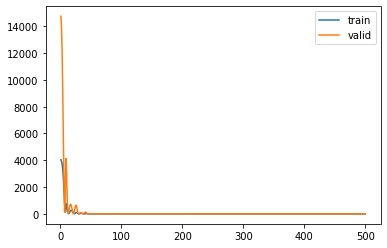

In [ ]:
epoch_count = range(1, len(history1['loss']) + 1)
sns.lineplot(x=epoch_count,  y=history1['loss'], label='train')
sns.lineplot(x=epoch_count,  y=history1['val_loss'], label='valid')
plt.show()

In [ ]:
# Ensayo
x_test = [50, 51, 52]
y_test = sum(x_test)
test_input = np.array([x_test])
test_input = test_input.reshape((1, seq_length, input_size))
test_input = torch.from_numpy(test_input.astype(np.float32))

test_target = torch.from_numpy(np.array(y_test).astype(np.int32)).float().view(-1, 1)

y_hat = model1(test_input)

print("y_test:", y_test)
print("y_hat:", y_hat)

loss = model1_criterion(y_hat, test_target).item()
print("loss:", loss)

y_test: 153
y_hat: tensor([[153.4888]], grad_fn=<AddmmBackward0>)
loss: 0.2389553189277649


### 3 - Bidirectional RNN (BRNN)

Como la implementación de "CustomLSTM" no soporta el flag de "bidirectional" que trae Pytorch, utilizaremos la layer por defecto de LSTM. Por eso notará que la cantidad de parámetros con bidireccional no es exactamente el doble (porque pytorch agrega otro bias a la ecuación tradicional).\
La única desventaja en este caso, al tratarse de una serie temporal no podremos utilizar la función de activación "relu" y por lo tanto el resultado alcanzado no será tan bueno como con la CustomLSTM.

In [ ]:
from torch_helpers import CustomLSTM

# En esta oportunidad se utilizará Bidirectional, dentro se especifica
# que lo que se desea hacer bidireccional es una capa LSTM

# En el summary se puede observar que la cantidad de parámetros
# de nuestor nueva capa LSTM bidireccional es el doble que la anterior

class Model2(nn.Module):
    def __init__(self, input_size, output_dim):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=64, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(in_features=2*64, out_features=output_dim) #  # Fully connected layer
        
    def forward(self, x):
        lstm_output, _ = self.lstm1(x)
        out = self.fc(lstm_output[:,-1,:]) # take last output (last seq)
        return out

model2 = Model2(input_size=input_size, output_dim=output_dim)

# Crear el optimizador la una función de error
model2_optimizer = torch.optim.Adam(model2.parameters(), lr=0.01)
model2_criterion = nn.MSELoss()  # mean squared error

summary(model2, input_size=(1, seq_length, input_size))

Layer (type:depth-idx)                   Output Shape              Param #
Model2                                   [1, 1]                    --
├─LSTM: 1-1                              [1, 3, 128]               34,304
├─Linear: 1-2                            [1, 1]                    129
Total params: 34,433
Trainable params: 34,433
Non-trainable params: 0
Total mult-adds (M): 0.10
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.14
Estimated Total Size (MB): 0.14

In [ ]:
history2 = train(model2,
                train_loader,
                valid_loader,
                model2_optimizer,
                model2_criterion,
                epochs=500
                )

Epoch: 1/500 - Train loss 4005.948 - Valid Loss 14907.582
Epoch: 2/500 - Train loss 3921.674 - Valid Loss 14727.104
Epoch: 3/500 - Train loss 3836.231 - Valid Loss 14530.659
Epoch: 4/500 - Train loss 3746.846 - Valid Loss 14321.375
Epoch: 5/500 - Train loss 3652.673 - Valid Loss 14093.188
Epoch: 6/500 - Train loss 3552.495 - Valid Loss 13848.782
Epoch: 7/500 - Train loss 3449.546 - Valid Loss 13596.863
Epoch: 8/500 - Train loss 3347.648 - Valid Loss 13344.054
Epoch: 9/500 - Train loss 3249.293 - Valid Loss 13100.435
Epoch: 10/500 - Train loss 3154.894 - Valid Loss 12865.003
Epoch: 11/500 - Train loss 3062.719 - Valid Loss 12629.790
Epoch: 12/500 - Train loss 2971.169 - Valid Loss 12391.567
Epoch: 13/500 - Train loss 2879.835 - Valid Loss 12151.559
Epoch: 14/500 - Train loss 2789.029 - Valid Loss 11913.071
Epoch: 15/500 - Train loss 2699.112 - Valid Loss 11677.581
Epoch: 16/500 - Train loss 2610.190 - Valid Loss 11445.011
Epoch: 17/500 - Train loss 2522.455 - Valid Loss 11215.792
Epoch:

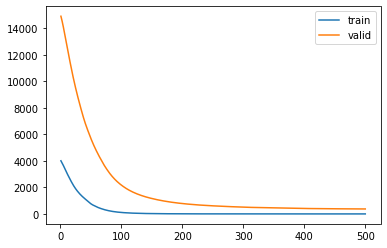

In [ ]:
epoch_count = range(1, len(history2['loss']) + 1)
sns.lineplot(x=epoch_count,  y=history2['loss'], label='train')
sns.lineplot(x=epoch_count,  y=history2['val_loss'], label='valid')
plt.show()

In [ ]:
# Ensayo
x_test = [50, 51, 52]
y_test = sum(x_test)
test_input = np.array([x_test])
test_input = test_input.reshape((1, seq_length, input_size))
test_input = torch.from_numpy(test_input.astype(np.float32))

test_target = torch.from_numpy(np.array(y_test).astype(np.int32)).float().view(-1, 1)

y_hat = model2(test_input)

print("y_test:", y_test)
print("y_hat:", y_hat)

loss = model2_criterion(y_hat, test_target).item()
print("loss:", loss)

y_test: 153
y_hat: tensor([[104.9728]], grad_fn=<AddmmBackward0>)
loss: 2306.611083984375


### 4 - Conclusión
Implementar un modelo bidireccional basado en RNN (en este caso LSTM) es muy sensillo. En este ejemplo no se explotó su potencialidad pero queda como nota de como implementar una capa BRNN.